# increasing number of genes to show increasing classification accuracy

In [ ]:
#! lamin init --storage ./lamin-intro --schema bionty

import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download
from scprint.tasks import Embedder

from scipy.stats import spearmanr
from anndata import AnnData

%load_ext autoreload
%autoreload 2

import torch

torch.set_float32_matmul_precision("medium")


LOC = "/pasteur/appa/scratch/jkalfon/data/spcrint_data/temp/" #"../../data/temp/"  #

→ connected lamindb: jkobject/scprint2


/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [1]:
adata = sc.read(
    LOC + "glio_smart_cort_area" + ".h5ad",
    backup_url="https://datasets.cellxgene.cziscience.com/a1d40c84-c81c-406f-bef4-e25edeb651e5.h5ad",
)

In [2]:
adata = sc.read(
    LOC + "glio_smart_highdepth" + ".h5ad",
    backup_url="https://datasets.cellxgene.cziscience.com/6ec440b4-542a-4022-ac01-56f812e25593.h5ad",
)

In [4]:
(adata.X > 0).sum(1).mean()

np.float64(7376.551793917073)

In [6]:
adata.obs.cell_type.value_counts()

cell_type
glutamatergic neuron                                              21841
L2/3-6 intratelencephalic projecting glutamatergic neuron          4778
VIP GABAergic cortical interneuron                                 3533
pvalb GABAergic cortical interneuron                               2800
L6 corticothalamic-projecting glutamatergic cortical neuron        2556
lamp5 GABAergic cortical interneuron                               2434
sst GABAergic cortical interneuron                                 2358
unknown                                                            1985
oligodendrocyte                                                    1930
astrocyte                                                          1187
L6b glutamatergic cortical neuron                                  1080
near-projecting glutamatergic cortical neuron                       816
oligodendrocyte precursor cell                                      773
microglial cell                                       

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata)
sc.tl.umap(adata)


/tmp/ipykernel_4167988/3889774829.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.3)


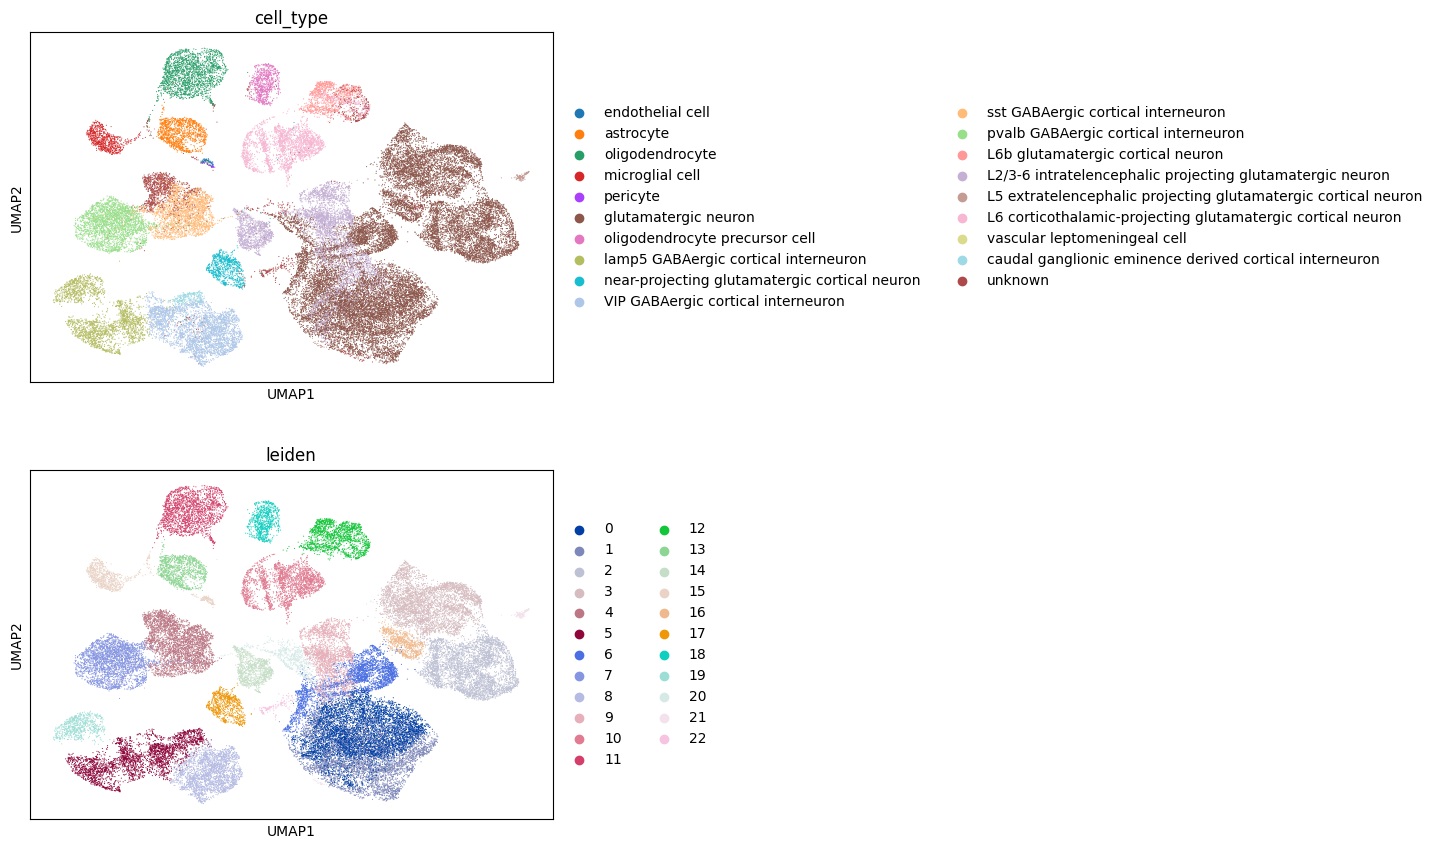

In [8]:
sc.tl.leiden(adata, resolution=0.3)
sc.pl.umap(adata, color=["cell_type", "leiden"], ncols=1)

In [8]:
preprocessor = Preprocessor(
    force_preprocess=True,
    skip_validate=True,
    # drop_non_primary=False,
    do_postp=False,
)
print("")
print(adata.X.sum(1).mean())
adata = preprocessor(adata)


1353725.5
Dropping layers:  KeysView(Layers with keys: exon, intron)
checking raw counts
removed 0 non primary cells, 49417 renamining
filtered out 0 cells, 49417 renamining
Removed 35 genes not known to the ontology
Removed 0 duplicate genes
Added 34853 genes in the ontology but not present in the dataset
starting QC
Seeing 10182 outliers (20.60% of total dataset):
done
AnnData object with n_obs × n_vars = 49417 × 70611
    obs: 'suspension_type', 'cluster', 'class', 'subclass', 'sex_ontology_term_id', 'region', 'cortical_layer', 'cell_type_accession', 'cell_type_alias', 'cell_type_alt_alias', 'cell_type_designation', 'donor_id', 'outlier_call', 'outlier_type', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'is_primary_data', 'cell_type_ontology_term_id', 'Specimen ID', 'sample_tissue_type', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cause_of_death', 'PMI (hr)', 'Tissue (RIN)', 'Hemisphere Sampled', 'tissue_typ

In [2]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
model_checkpoint_file = "../models/w937u4o1.ckpt"
# w937u4o1

In [1]:
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)
model = model.to("cuda")

NameError: name 'model_checkpoint_file' is not defined

In [ ]:
import numpy as np

In [ ]:
metrics = {}


for n in [200, 500, 1000, 2000, 4000, 8000]:
    ad = adata[(adata.X > 0).sum(1) >= n]
    # Get 5,000 random cells
    n_cells = min(5000, ad.n_obs)  # In case you have fewer than 5,000 cells
    random_indices = np.random.choice(ad.n_obs, n_cells, replace=False)
    adata_subset = ad[random_indices, :].copy()
    embed = Embedder(
        how="random expr",
        max_len=n,
        num_workers=8,
        pred_embedding=["cell_type_ontology_term_id"],
        doplot=False,
    )
    _, metrics[n] = embed(model, adata_subset.copy())

not on wandb, could not set name


100%|██████████| 79/79 [05:12<00:00,  3.96s/it]


logging the anndata
AnnData object with n_obs × n_vars = 5000 × 20004
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


In [15]:
metrics

{200: {'cell_type_ontology_term_id_accuracy': 0.5786189683860233,
  'tissue_ontology_term_id_accuracy': 0.1258,
  'disease_ontology_term_id_accuracy': 0.9982,
  'assay_ontology_term_id_accuracy': 0.7746,
  'self_reported_ethnicity_ontology_term_id_accuracy': 0.6224,
  'sex_ontology_term_id_accuracy': 0.5468,
  'organism_ontology_term_id_accuracy': 0.9844},
 500: {'cell_type_ontology_term_id_accuracy': 0.6015869701399039,
  'tissue_ontology_term_id_accuracy': 0.1318,
  'disease_ontology_term_id_accuracy': 0.9958,
  'assay_ontology_term_id_accuracy': 0.8722,
  'self_reported_ethnicity_ontology_term_id_accuracy': 0.6232,
  'sex_ontology_term_id_accuracy': 0.5844,
  'organism_ontology_term_id_accuracy': 0.9998},
 1000: {'cell_type_ontology_term_id_accuracy': 0.6082151793160967,
  'tissue_ontology_term_id_accuracy': 0.1286,
  'disease_ontology_term_id_accuracy': 0.9906,
  'assay_ontology_term_id_accuracy': 0.8844,
  'self_reported_ethnicity_ontology_term_id_accuracy': 0.6232,
  'sex_ontolog

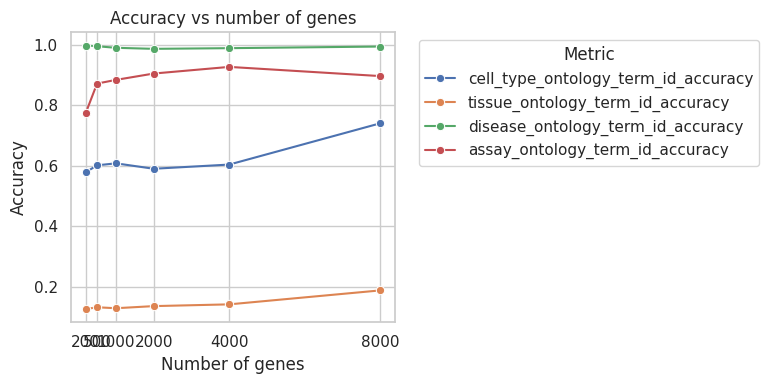

In [6]:
import pandas as pd
import seaborn as sns

metrics = {
    200: {
        "cell_type_ontology_term_id_accuracy": 0.5786189683860233,
        "tissue_ontology_term_id_accuracy": 0.1258,
        "disease_ontology_term_id_accuracy": 0.9982,
        "assay_ontology_term_id_accuracy": 0.7746,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.6224,
        "sex_ontology_term_id_accuracy": 0.5468,
        "organism_ontology_term_id_accuracy": 0.9844,
    },
    500: {
        "cell_type_ontology_term_id_accuracy": 0.6015869701399039,
        "tissue_ontology_term_id_accuracy": 0.1318,
        "disease_ontology_term_id_accuracy": 0.9958,
        "assay_ontology_term_id_accuracy": 0.8722,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.6232,
        "sex_ontology_term_id_accuracy": 0.5844,
        "organism_ontology_term_id_accuracy": 0.9998,
    },
    1000: {
        "cell_type_ontology_term_id_accuracy": 0.6082151793160967,
        "tissue_ontology_term_id_accuracy": 0.1286,
        "disease_ontology_term_id_accuracy": 0.9906,
        "assay_ontology_term_id_accuracy": 0.8844,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.6232,
        "sex_ontology_term_id_accuracy": 0.7122,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    2000: {
        "cell_type_ontology_term_id_accuracy": 0.5902530851286342,
        "tissue_ontology_term_id_accuracy": 0.1356,
        "disease_ontology_term_id_accuracy": 0.9872,
        "assay_ontology_term_id_accuracy": 0.9054,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.6376,
        "sex_ontology_term_id_accuracy": 0.861,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    4000: {
        "cell_type_ontology_term_id_accuracy": 0.6041275797373359,
        "tissue_ontology_term_id_accuracy": 0.1414,
        "disease_ontology_term_id_accuracy": 0.9894,
        "assay_ontology_term_id_accuracy": 0.9274,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.6214,
        "sex_ontology_term_id_accuracy": 0.974,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    8000: {
        "cell_type_ontology_term_id_accuracy": 0.7407175636211931,
        "tissue_ontology_term_id_accuracy": 0.1876,
        "disease_ontology_term_id_accuracy": 0.9948,
        "assay_ontology_term_id_accuracy": 0.897,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.599,
        "sex_ontology_term_id_accuracy": 0.9828,
        "organism_ontology_term_id_accuracy": 1.0,
    },
}

import matplotlib.pyplot as plt

# create a DataFrame from the metrics dict
df = pd.DataFrame(metrics).T.reset_index().rename(columns={"index": "n_genes"})

# keep only the four metrics to plot
cols = [
    "cell_type_ontology_term_id_accuracy",
    "tissue_ontology_term_id_accuracy",
    "disease_ontology_term_id_accuracy",
    "assay_ontology_term_id_accuracy",
]
df = df[["n_genes"] + cols].sort_values("n_genes")

# melt for seaborn
df_melt = df.melt(
    id_vars="n_genes", value_vars=cols, var_name="metric", value_name="accuracy"
)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_melt, x="n_genes", y="accuracy", hue="metric", marker="o")
plt.xticks(df["n_genes"])
plt.xlabel("Number of genes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs number of genes")
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

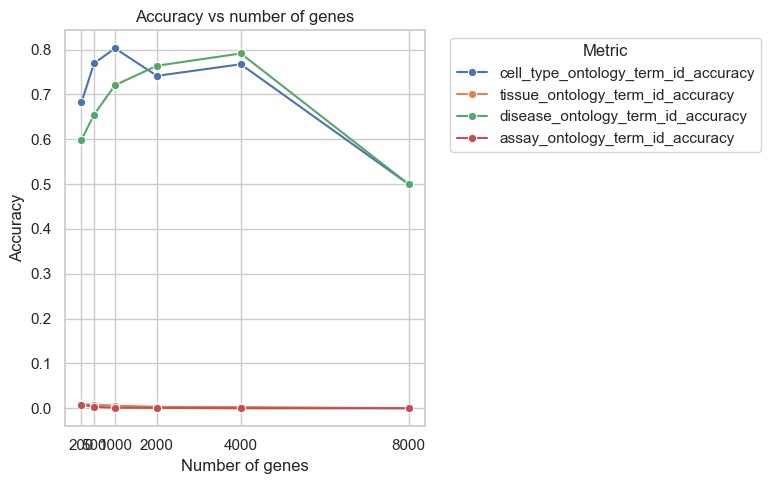

In [17]:
metrics = {
    200: {
        "cell_type_ontology_term_id_accuracy": 0.6820857863751051,
        "tissue_ontology_term_id_accuracy": 0.008690776562938042,
        "disease_ontology_term_id_accuracy": 0.5988225399495374,
        "assay_ontology_term_id_accuracy": 0.00784973366975049,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    500: {
        "cell_type_ontology_term_id_accuracy": 0.7693831352574986,
        "tissue_ontology_term_id_accuracy": 0.008205998868138087,
        "disease_ontology_term_id_accuracy": 0.6550650820599887,
        "assay_ontology_term_id_accuracy": 0.003395585738539898,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    1000: {
        "cell_type_ontology_term_id_accuracy": 0.8029069767441861,
        "tissue_ontology_term_id_accuracy": 0.005813953488372093,
        "disease_ontology_term_id_accuracy": 0.7206395348837209,
        "assay_ontology_term_id_accuracy": 0.0011627906976744186,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    2000: {
        "cell_type_ontology_term_id_accuracy": 0.7415273384545865,
        "tissue_ontology_term_id_accuracy": 0.0031631269769543608,
        "disease_ontology_term_id_accuracy": 0.7641211025756891,
        "assay_ontology_term_id_accuracy": 0.0009037505648441031,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    4000: {
        "cell_type_ontology_term_id_accuracy": 0.767379679144385,
        "tissue_ontology_term_id_accuracy": 0.00267379679144385,
        "disease_ontology_term_id_accuracy": 0.7914438502673797,
        "assay_ontology_term_id_accuracy": 0.0,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    8000: {
        "cell_type_ontology_term_id_accuracy": 0.5,
        "tissue_ontology_term_id_accuracy": 0.0,
        "disease_ontology_term_id_accuracy": 0.5,
        "assay_ontology_term_id_accuracy": 0.0,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
}

import matplotlib.pyplot as plt

# create a DataFrame from the metrics dict
df = pd.DataFrame(metrics).T.reset_index().rename(columns={"index": "n_genes"})

# keep only the four metrics to plot
cols = [
    "cell_type_ontology_term_id_accuracy",
    "tissue_ontology_term_id_accuracy",
    "disease_ontology_term_id_accuracy",
    "assay_ontology_term_id_accuracy",
]
df = df[["n_genes"] + cols].sort_values("n_genes")

# melt for seaborn
df_melt = df.melt(
    id_vars="n_genes", value_vars=cols, var_name="metric", value_name="accuracy"
)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_melt, x="n_genes", y="accuracy", hue="metric", marker="o")
plt.xticks(df["n_genes"])
plt.xlabel("Number of genes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs number of genes")
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

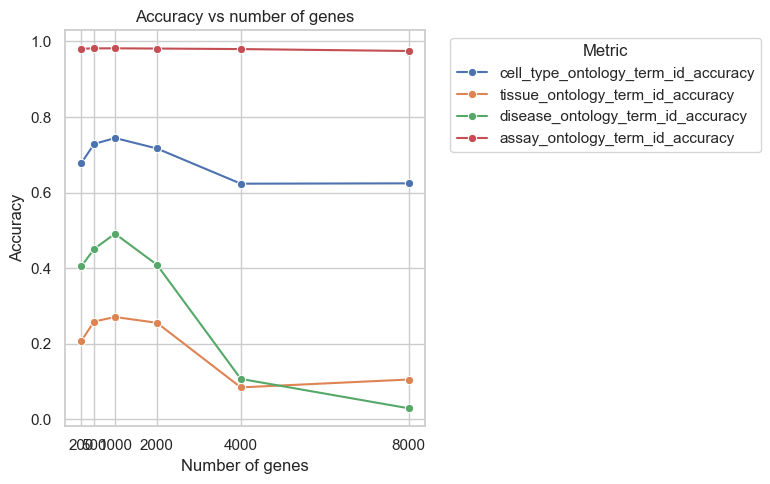

In [18]:
metrics = {
    200: {
        "cell_type_ontology_term_id_accuracy": 0.6787216148023549,
        "tissue_ontology_term_id_accuracy": 0.2082982898794505,
        "disease_ontology_term_id_accuracy": 0.4053826745164003,
        "assay_ontology_term_id_accuracy": 0.9806560134566863,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    500: {
        "cell_type_ontology_term_id_accuracy": 0.728623493131483,
        "tissue_ontology_term_id_accuracy": 0.2590412111017662,
        "disease_ontology_term_id_accuracy": 0.4510793383795907,
        "assay_ontology_term_id_accuracy": 0.9817774039809364,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    1000: {
        "cell_type_ontology_term_id_accuracy": 0.7446033081020466,
        "tissue_ontology_term_id_accuracy": 0.27109615923745445,
        "disease_ontology_term_id_accuracy": 0.49144939725259323,
        "assay_ontology_term_id_accuracy": 0.9817774039809364,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    2000: {
        "cell_type_ontology_term_id_accuracy": 0.7168488926268572,
        "tissue_ontology_term_id_accuracy": 0.255677039529016,
        "disease_ontology_term_id_accuracy": 0.40930754135127556,
        "assay_ontology_term_id_accuracy": 0.9812167087188113,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    4000: {
        "cell_type_ontology_term_id_accuracy": 0.6237734791141015,
        "tissue_ontology_term_id_accuracy": 0.08494533221194281,
        "disease_ontology_term_id_accuracy": 0.10737314269694422,
        "assay_ontology_term_id_accuracy": 0.9798149705634988,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    8000: {
        "cell_type_ontology_term_id_accuracy": 0.6246145220072891,
        "tissue_ontology_term_id_accuracy": 0.10569105691056911,
        "disease_ontology_term_id_accuracy": 0.02971684889262686,
        "assay_ontology_term_id_accuracy": 0.9747687132043734,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
}

import matplotlib.pyplot as plt

# create a DataFrame from the metrics dict
df = pd.DataFrame(metrics).T.reset_index().rename(columns={"index": "n_genes"})

# keep only the four metrics to plot
cols = [
    "cell_type_ontology_term_id_accuracy",
    "tissue_ontology_term_id_accuracy",
    "disease_ontology_term_id_accuracy",
    "assay_ontology_term_id_accuracy",
]
df = df[["n_genes"] + cols].sort_values("n_genes")

# melt for seaborn
df_melt = df.melt(
    id_vars="n_genes", value_vars=cols, var_name="metric", value_name="accuracy"
)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_melt, x="n_genes", y="accuracy", hue="metric", marker="o")
plt.xticks(df["n_genes"])
plt.xlabel("Number of genes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs number of genes")
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
metrics = {}
for n in [200, 500, 1000, 2000, 4000, 8000]:
    embed = Embedder(
        how="most expr",
        max_len=n,
        num_workers=8,
        pred_embedding=["cell_type_ontology_term_id"],
        doplot=False,
    )
    _, metrics[n] = embed(model, adata.copy())

not on wandb, could not set name


100%|██████████| 56/56 [00:05<00:00, 11.08it/s]


logging the anndata
AnnData object with n_obs × n_vars = 3567 × 335182
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering
not on wandb, could not set name


100%|██████████| 56/56 [00:03<00:00, 14.88it/s]


logging the anndata
AnnData object with n_obs × n_vars = 3567 × 335182
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering
not on wandb, could not set name


100%|██████████| 56/56 [00:04<00:00, 11.50it/s]


logging the anndata
AnnData object with n_obs × n_vars = 3567 × 335182
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering
not on wandb, could not set name


100%|██████████| 56/56 [00:09<00:00,  5.90it/s]


logging the anndata
AnnData object with n_obs × n_vars = 3567 × 335182
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering
not on wandb, could not set name


100%|██████████| 56/56 [00:23<00:00,  2.35it/s]


logging the anndata
AnnData object with n_obs × n_vars = 3567 × 335182
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering
not on wandb, could not set name


100%|██████████| 56/56 [01:11<00:00,  1.28s/it]


logging the anndata
AnnData object with n_obs × n_vars = 3567 × 335182
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


In [9]:
metrics

{200: {'cell_type_ontology_term_id_accuracy': 0.5290159798149706,
  'tissue_ontology_term_id_accuracy': 0.11101766190075694,
  'disease_ontology_term_id_accuracy': 0.27782450238295486,
  'assay_ontology_term_id_accuracy': 0.9873843566021867,
  'self_reported_ethnicity_ontology_term_id_accuracy': 1.0,
  'sex_ontology_term_id_accuracy': 1.0,
  'organism_ontology_term_id_accuracy': 1.0},
 500: {'cell_type_ontology_term_id_accuracy': 0.5511634426689095,
  'tissue_ontology_term_id_accuracy': 0.14325763947294645,
  'disease_ontology_term_id_accuracy': 0.5071488645920942,
  'assay_ontology_term_id_accuracy': 0.9857022708158116,
  'self_reported_ethnicity_ontology_term_id_accuracy': 1.0,
  'sex_ontology_term_id_accuracy': 1.0,
  'organism_ontology_term_id_accuracy': 1.0},
 1000: {'cell_type_ontology_term_id_accuracy': 0.592094196804037,
  'tissue_ontology_term_id_accuracy': 0.25848051583964116,
  'disease_ontology_term_id_accuracy': 0.6613400616764789,
  'assay_ontology_term_id_accuracy': 0.98

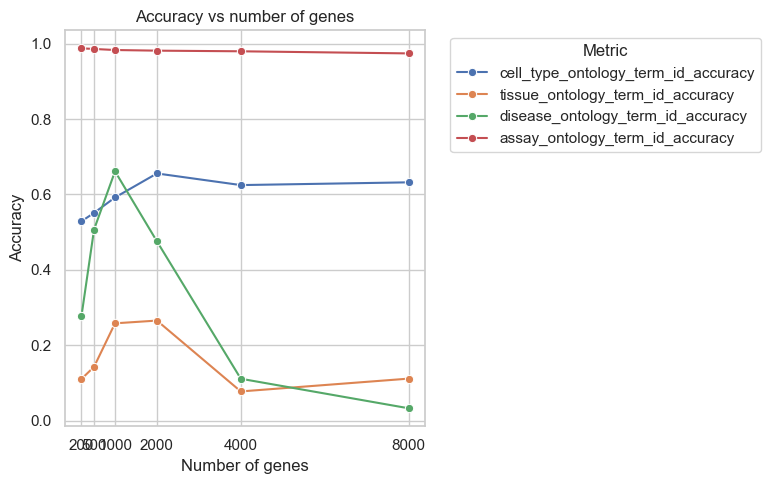

In [8]:
import pandas as pd
import seaborn as sns

metrics = {
    200: {
        "cell_type_ontology_term_id_accuracy": 0.5290159798149706,
        "tissue_ontology_term_id_accuracy": 0.11101766190075694,
        "disease_ontology_term_id_accuracy": 0.27782450238295486,
        "assay_ontology_term_id_accuracy": 0.9873843566021867,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    500: {
        "cell_type_ontology_term_id_accuracy": 0.5511634426689095,
        "tissue_ontology_term_id_accuracy": 0.14325763947294645,
        "disease_ontology_term_id_accuracy": 0.5071488645920942,
        "assay_ontology_term_id_accuracy": 0.9857022708158116,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    1000: {
        "cell_type_ontology_term_id_accuracy": 0.592094196804037,
        "tissue_ontology_term_id_accuracy": 0.25848051583964116,
        "disease_ontology_term_id_accuracy": 0.6613400616764789,
        "assay_ontology_term_id_accuracy": 0.9828987945051865,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    2000: {
        "cell_type_ontology_term_id_accuracy": 0.6557331090552285,
        "tissue_ontology_term_id_accuracy": 0.2657695542472666,
        "disease_ontology_term_id_accuracy": 0.47574992991309223,
        "assay_ontology_term_id_accuracy": 0.9812167087188113,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    4000: {
        "cell_type_ontology_term_id_accuracy": 0.6248948696383515,
        "tissue_ontology_term_id_accuracy": 0.07793664143537987,
        "disease_ontology_term_id_accuracy": 0.11157835716288197,
        "assay_ontology_term_id_accuracy": 0.9795346229324362,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    8000: {
        "cell_type_ontology_term_id_accuracy": 0.632183908045977,
        "tissue_ontology_term_id_accuracy": 0.1118587047939445,
        "disease_ontology_term_id_accuracy": 0.03336136809643959,
        "assay_ontology_term_id_accuracy": 0.9739276703111859,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
}

import matplotlib.pyplot as plt

# create a DataFrame from the metrics dict
df = pd.DataFrame(metrics).T.reset_index().rename(columns={"index": "n_genes"})

# keep only the four metrics to plot
cols = [
    "cell_type_ontology_term_id_accuracy",
    "tissue_ontology_term_id_accuracy",
    "disease_ontology_term_id_accuracy",
    "assay_ontology_term_id_accuracy",
]
df = df[["n_genes"] + cols].sort_values("n_genes")

# melt for seaborn
df_melt = df.melt(
    id_vars="n_genes", value_vars=cols, var_name="metric", value_name="accuracy"
)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_melt, x="n_genes", y="accuracy", hue="metric", marker="o")
plt.xticks(df["n_genes"])
plt.xlabel("Number of genes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs number of genes")
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# with the novel annotation remapping

In [7]:
adata

AnnData object with n_obs × n_vars = 3567 × 70611
    obs: 'Sample.type', 'Selection', 'Location', 'Sample.name', 'Total_reads', 'Unique_reads', 'Unique_reads_percent', 'Splice_sites_total', 'Splice_sites_Annotated', 'Splice_sites_GT.AG', 'Splice_sites_GC.AG', 'Splice_sites_AT.AC', 'Splice_sites_non_canonical', 'Multimapping_reads_percent', 'Unmapped_mismatch', 'Unmapped_short', 'Unmapped_other', 'ERCC_reads', 'Non_ERCC_reads', 'ERCC_to_non_ERCC', 'Genes_detected', 'housekeeping_cluster', 'Cluster_2d', 'Cluster_2d_color', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nnz', 'n_genes', 'n_genes_by

In [ ]:
(adata.X > 0).sum(1).mean()

np.float64(2524.4379029997194)

In [ ]:
adata.obs["assay_ontology_term_id"].value_counts()

assay_ontology_term_id
EFO:0008931    3567
Name: count, dtype: int64

In [ ]:
embed = Embedder(
    how="random expr",
    max_len=1000,
    num_workers=8,
    pred_embedding=["cell_type_ontology_term_id"],
    doplot=False,
    # keep_all_labels_pred=True,
)
# nadata, metrics = embed(model, adata.copy())

In [21]:
metrics

{'cell_type_ontology_term_id_accuracy': 0.7869358003924867,
 'tissue_ontology_term_id_accuracy': 0.007289038407625455,
 'disease_ontology_term_id_accuracy': 0.7109615923745445,
 'assay_ontology_term_id_accuracy': 0.00112139052425007,
 'self_reported_ethnicity_ontology_term_id_accuracy': 1.0,
 'sex_ontology_term_id_accuracy': 1.0,
 'organism_ontology_term_id_accuracy': 1.0}

In [24]:
sc.pp.normalize_total(nadata, target_sum=1e6)
sc.pp.log1p(nadata)
sc.tl.pca(nadata, n_comps=50)
sc.pp.neighbors(nadata)
sc.tl.umap(nadata)


In [25]:
from scprint.utils.graph_refinement import zero_shot_annotation_with_refinement
from scdataloader.utils import translate
from scprint.tasks.cell_emb import compute_classification

In [69]:
nadata.obs["pred_tissue_ontology_term_id"].value_counts()

pred_tissue_ontology_term_id
UBERON:0002299    2246
UBERON:0002661    1025
UBERON:0001886     226
UBERON:0002132      61
UBERON:0003403       3
UBERON:0014648       3
UBERON:0002756       1
UBERON:0012168       1
UBERON:0002351       1
Name: count, dtype: int64

In [ ]:
"UBERON:0002299"

In [71]:
translate(
    nadata.obs["pred_tissue_ontology_term_id"].value_counts().keys().tolist(),
    "tissue_ontology_term_id",
)

['alveolus of lung',
 'superior frontal gyrus',
 'choroid plexus',
 'dentate nucleus',
 'skin of forearm',
 'hemisphere part of cerebellar posterior lobe',
 'anterior cingulate gyrus',
 'umbilical cord blood',
 'sinoatrial node']

In [ ]:
# res = nadata.obs.iloc[:, 564:783].values#.argmax(1)
res = zero_shot_annotation_with_refinement(nadata.obs.iloc[:, 564:783].values, nadata)
nadata.obs["pred_tissue_ontology_term_id"] = [
    nadata.obs.columns[564:783][i] for i in res
]
compute_classification(
    nadata, ["tissue_ontology_term_id"], model.label_decoders, model.labels_hierarchy
)

PairwiseArrays with keys: distances, connectivities


{'tissue_ontology_term_id': {'accuracy': np.float64(0.0),
  'macro': 0.0,
  'micro': 0.0,
  'weighted': 0.0}}

In [27]:
res = zero_shot_annotation_with_refinement(nadata.obs.iloc[:, 1108:1135].values, nadata)
# res = nadata.obs.iloc[:, 1108:1135].values.argmax(1)
nadata.obs["pred_assay_ontology_term_id"] = [
    nadata.obs.columns[1108:1135][i] for i in res
]
compute_classification(
    nadata, ["assay_ontology_term_id"], model.label_decoders, model.labels_hierarchy
)
# -1% improv

PairwiseArrays with keys: distances, connectivities


{'assay_ontology_term_id': {'accuracy': np.float64(0.9764507989907485),
  'macro': 0.4940425531914894,
  'micro': 0.9764507989907485,
  'weighted': 0.9648164915985183}}

In [ ]:
# res = adata.obs.iloc[:, 783:1090].values.argmax(1)
res = zero_shot_annotation_with_refinement(nadata.obs.iloc[:, 783:1090].values, nadata)
nadata.obs["pred_disease_ontology_term_id"] = [
    nadata.obs.columns[783:1090][i] for i in res
]
compute_classification(
    nadata, ["disease_ontology_term_id"], model.label_decoders, model.labels_hierarchy
)
# +4% improv

PairwiseArrays with keys: distances, connectivities


{'disease_ontology_term_id': {'accuracy': np.float64(0.7947855340622372),
  'macro': 0.44283036551077787,
  'micro': 0.7947855340622372,
  'weighted': 0.7039103371029185}}

In [48]:
# res = adata.obs.iloc[:, 783:1090].values.argmax(1)

res = zero_shot_annotation_with_refinement(nadata.obs.iloc[:, 63:564].values, nadata)
nadata.obs["pred_cell_type_ontology_term_id"] = [
    nadata.obs.columns[63:564][i] for i in res
]
compute_classification(
    nadata, ["cell_type_ontology_term_id"], model.label_decoders, model.labels_hierarchy
)

PairwiseArrays with keys: distances, connectivities


{'cell_type_ontology_term_id': {'accuracy': np.float64(0.7636669470142977),
  'macro': 0.35765938733124936,
  'micro': 0.7636669470142977,
  'weighted': 0.7360438127690511}}

... storing 'conv_pred_cell_type_ontology_term_id' as categorical


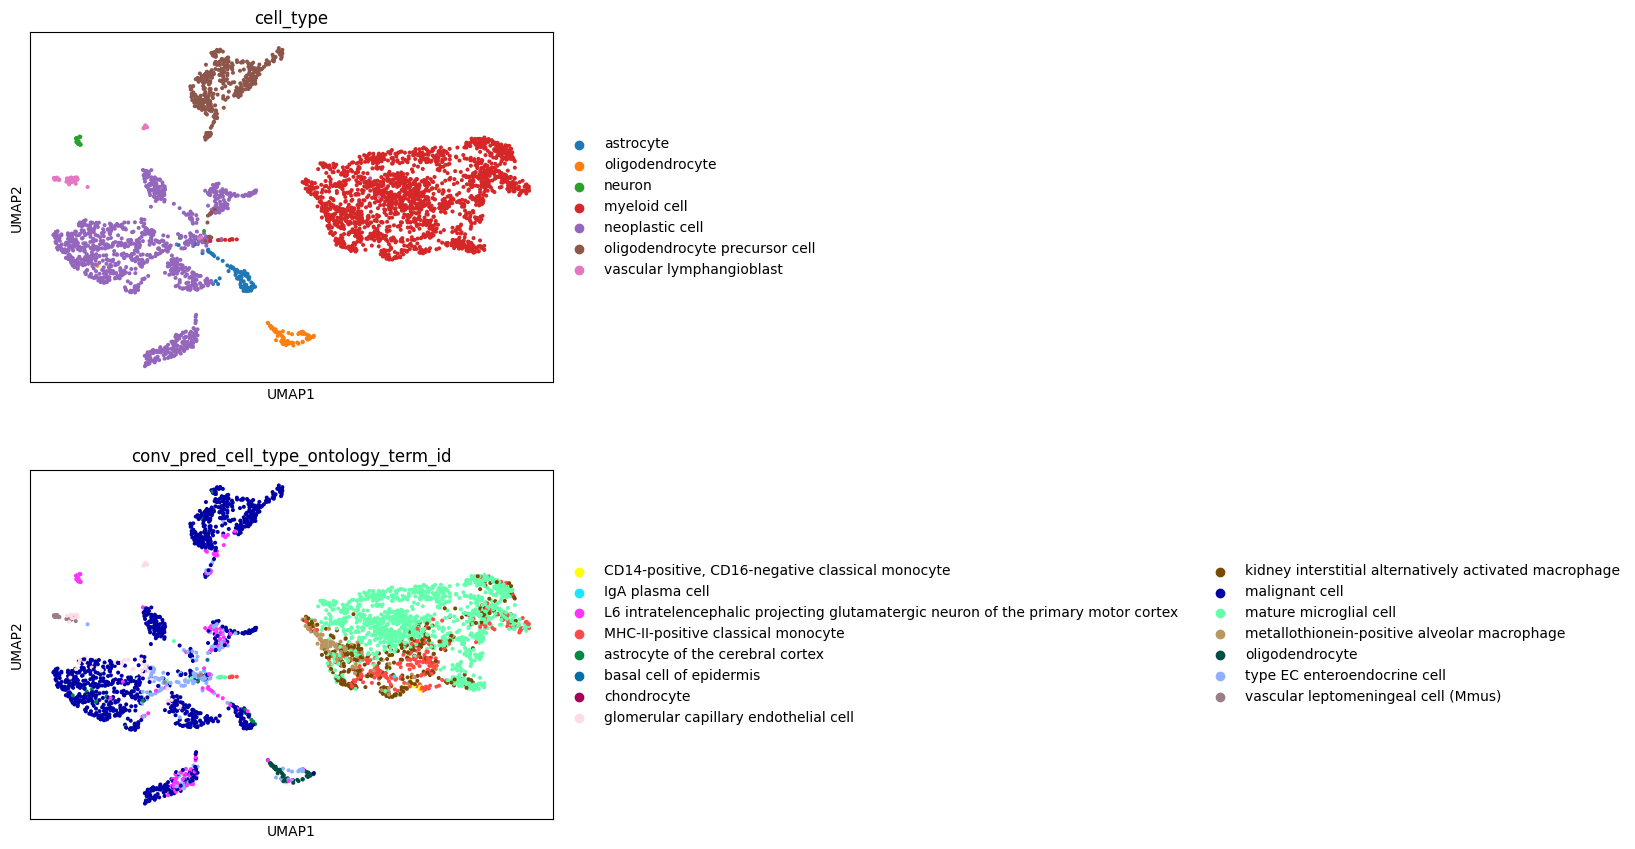

In [ ]:
sc.pl.umap(
    nadata,
    color=["cell_type", "conv_pred_cell_type_ontology_term_id"],
    ncols=1,
)

# H show a confusion matrix to the true labels (more coarse labels) for things were it was not super precise (or to coarse / non coarse labels)

In [11]:
from scprint.tasks import display_confusion_matrix

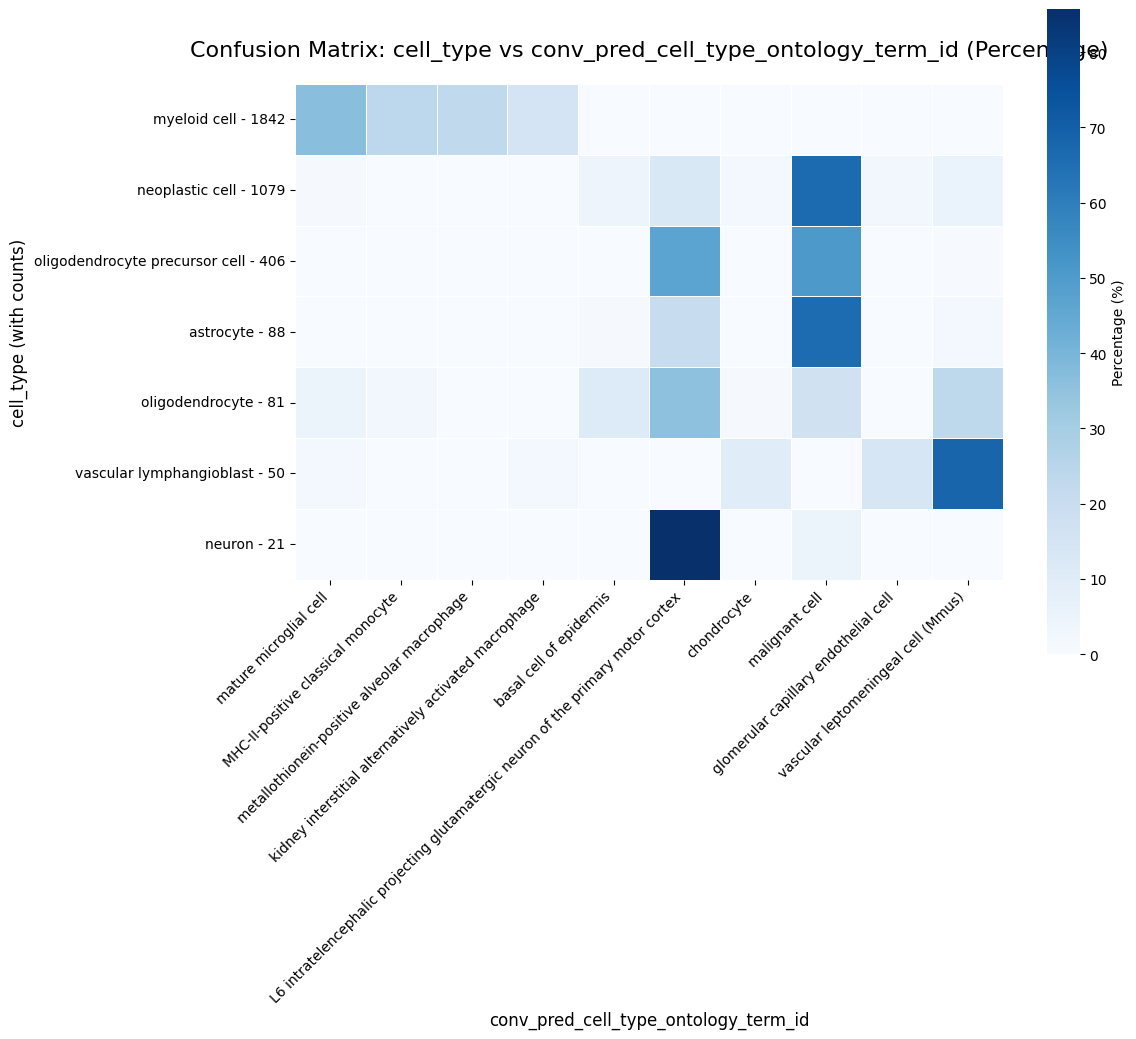

In [15]:
display_confusion_matrix(nadata)

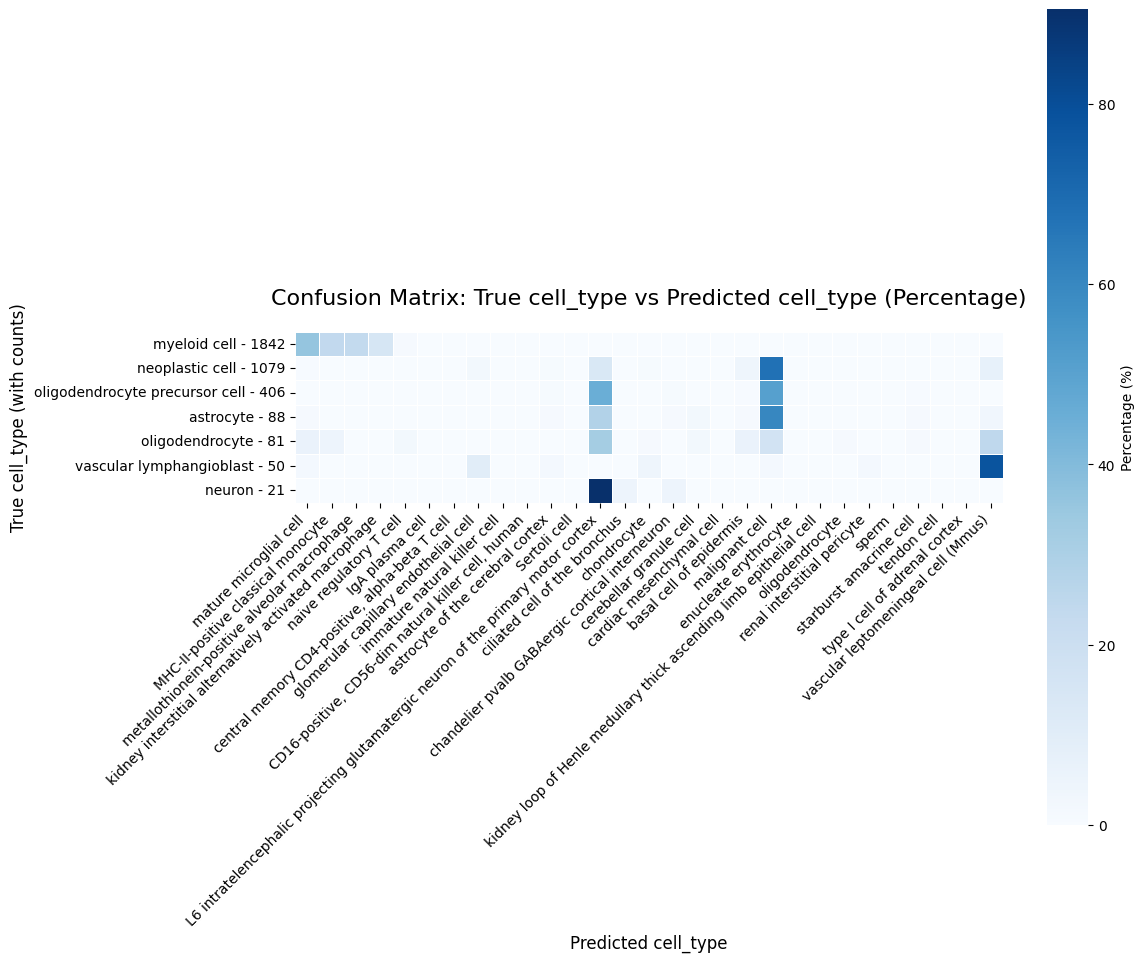

In [48]:
display_confusion_matrix(nadata, on="cell_type")


In [43]:
sc.pp.normalize_total(nadata, target_sum=10_000, inplace=True)
sc.pp.log1p(nadata)
sc.pp.pca(nadata, n_comps=50)

In [46]:
from scprint.utils.graph_refinement import zero_shot_annotation_with_refinement

In [51]:
nadata.obsp.get("connectivities") is None

True

In [58]:
pred = [nadata.obs.iloc[:, 63:564].columns[i] for i in res]

In [60]:
from scdataloader.utils import translate


In [68]:
clss = "cell_type_ontology_term_id"
tr = translate(pred, clss)
if tr is not None:
    nadata.obs["conv_pred_" + clss] = [tr[i] for i in pred]


In [ ]:
nadata.obs["pred_" + clss] = [
    nadata.obs.iloc[:, 63:564].columns[i]
    for i in nadata.obs.iloc[:, 63:564].values.argmax(axis=1)
]
# nadata.obs['pred_' + clss]= pred

In [ ]:
res = (
    nadata.obs[nadata.obs["cell_type"] == "oligodendrocyte precursor cell"]
    .iloc[:, 63:564]
    .max(0)
    .sort_values(ascending=False)
)

rn = translate(res.keys().tolist(), clss)
res = {rn[k]: v for k, v in res.items()}

In [ ]:
# interestingly max across cluster seems to make it almost better
# show first 3 items of res
list(res.items())[:3]

[('malignant cell', 2.287109375),
 ('L6 intratelencephalic projecting glutamatergic neuron of the primary motor cortex',
  1.9794921875),
 ('astrocyte of the cerebral cortex', 1.2490234375)]

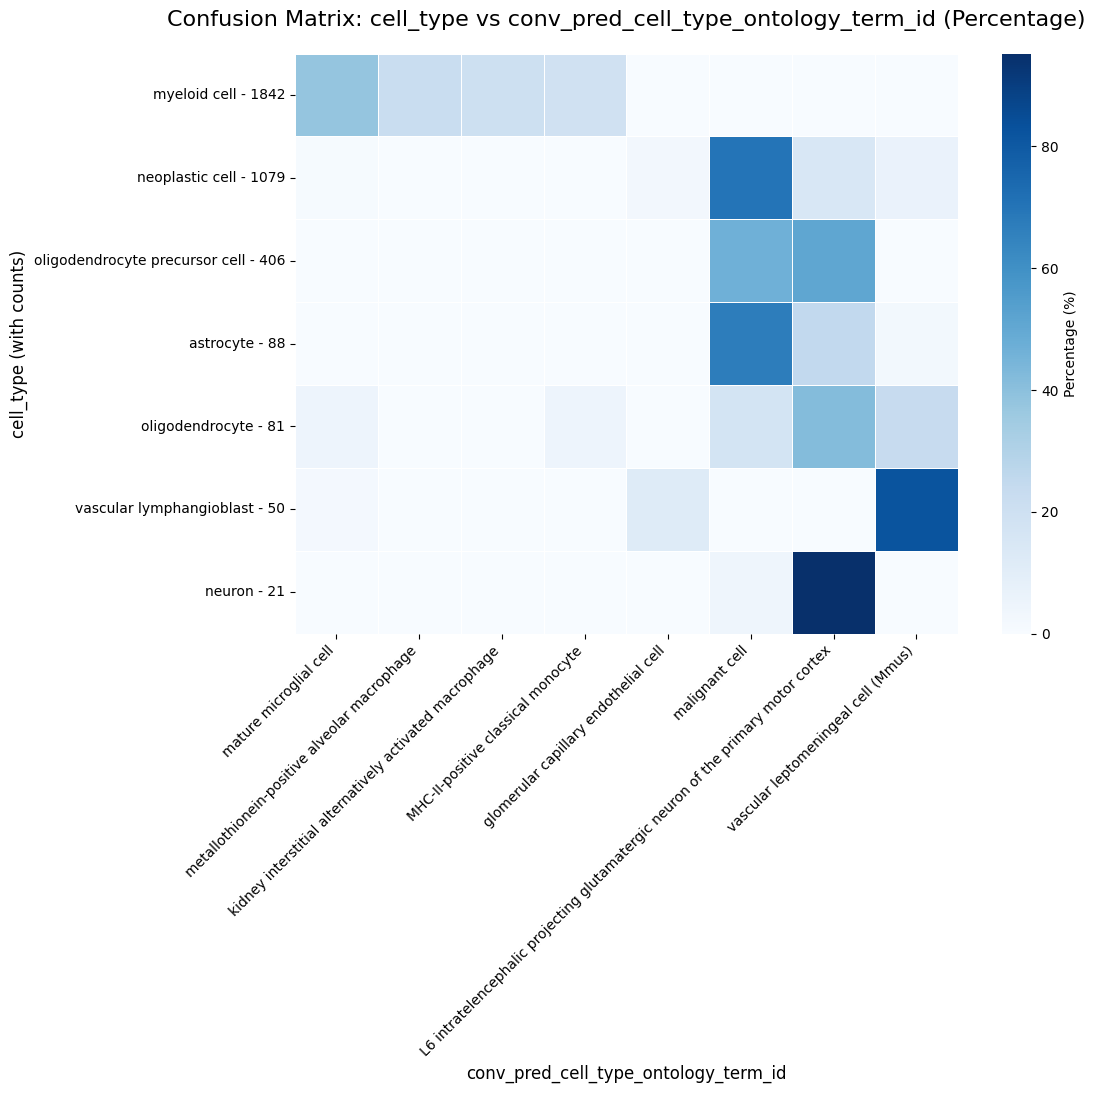

In [69]:
display_confusion_matrix(nadata)

In [ ]:
res = []
cur_labels_hierarchy = {
    model.label_decoders[clss][k]: [model.label_decoders[clss][i] for i in v]
    for k, v in model.labels_hierarchy[clss].items()
}
for pred, true in nadata.obs[["pred_" + clss, clss]].values:
    if pred == true:
        res.append(True)
        continue
    if len(cur_labels_hierarchy) > 0:
        if true in cur_labels_hierarchy:
            res.append(pred in cur_labels_hierarchy[true])
            continue
        elif true != "unknown":
            res.append(False)
    elif true != "unknown":
        res.append(False)
    # else true is unknown
    # else we pass
if len(res) == 0:
    # true was always unknown
    res = [1]
print("    ", clss)
print("     accuracy:", sum(res) / len(res))
print(" ")
metrics.update({clss + "_accuracy": sum(res) / len(res)})

     cell_type_ontology_term_id
     accuracy: 0.7146061115783572
 


#  conditional generation [cancer/non cancer or male / female] and differential expression analysis between the two.

In [ ]:
embed = Embedder(
    how="random expr",
    max_len=2000,
    num_workers=8,
    pred_embedding=[
        "cell_type_ontology_term_id",
    ],
    doplot=True,
    # keep_all_labels_pred=True,
)
nadata, metrics = embed(model, adata.copy(), cache=False)

# finetuning